# Required modules

In [11]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
%matplotlib inline
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch.autograd import Variable
import numpy as np
import torchmetrics
device = torch.device('cpu')
import tqdm
from torchsummary import summary


from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt




### Split the MNIST dataset in train / test

We get the dataset from the PyTorch library. Then we splitted into the train and test set. There are two transormations throughout the data acquisition:
- We transform the images into Tensors
- Normalize the images - to have all the numerical values common scale

In [2]:
BATCH_SIZE = 128

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)), # The values are the std and the mean of the mnist dataset
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('mnist_data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)),
                   ])),
    batch_size=BATCH_SIZE, shuffle=True)

/Users/manoskoutoulakis/miniforge3/envs/dl/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /tmp/pip-req-build-jhk0fkj8/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
print("Train set:\n")
print(train_loader.dataset)
print("\nTest set:\n")
print(test_loader.dataset)

Train set:

Dataset MNIST
    Number of datapoints: 60000
    Root location: mnist_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

Test set:

Dataset MNIST
    Number of datapoints: 10000
    Root location: mnist_data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )


## CNN and CAE models

This phase is the construction of the Convolutional Neural Network and the Convolutional Auto-Encoder

Check how to calculate the output size
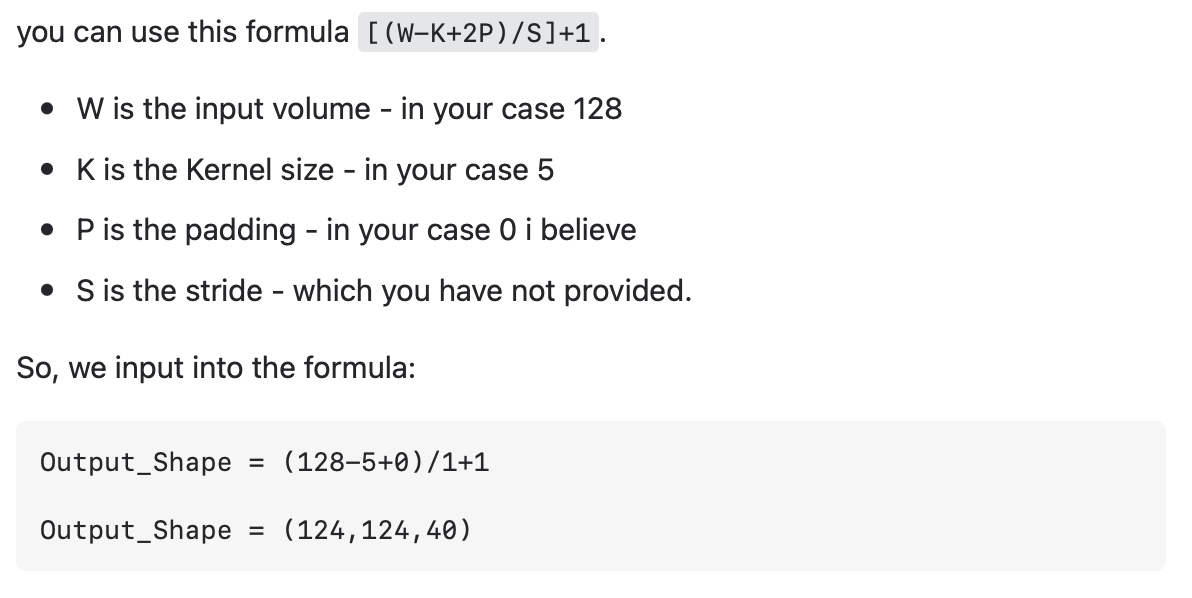

### CNN model architecture 

In the cell below we have defined a simple neural network architecture


In [104]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels= 1, out_channels= 8, kernel_size= 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= 2,stride= 1),

            nn.Conv2d(in_channels= 8, out_channels= 16, kernel_size= 3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= 2,stride= 3),
        )
        self.fc_layers = nn.Sequential(
            
            nn.Linear(in_features= 16*8*8, out_features= 120),
            nn.ReLU(),
            
            nn.Linear(in_features= 120, out_features= 60),
            nn.ReLU(),
            
            nn.Linear(in_features= 60, out_features= 10),
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.reshape(-1, 16*8*8)
        x = self.fc_layers(x)
        return x
    
test = CNN()
summary(test, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              80
              ReLU-2            [-1, 8, 26, 26]               0
         MaxPool2d-3            [-1, 8, 25, 25]               0
            Conv2d-4           [-1, 16, 23, 23]           1,168
              ReLU-5           [-1, 16, 23, 23]               0
         MaxPool2d-6             [-1, 16, 8, 8]               0
            Linear-7                  [-1, 120]         123,000
              ReLU-8                  [-1, 120]               0
            Linear-9                   [-1, 60]           7,260
             ReLU-10                   [-1, 60]               0
           Linear-11                   [-1, 10]             610
Total params: 132,118
Trainable params: 132,118
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/

### CAE Model architecture

The next cell is the CAE architecture.
We separate the Encoder and the Decoder in order to be able to handle the output of the encoder (by adding noise etc.)

In [15]:
class Encoder(nn.Module):
    def __init__(self,):
        super().__init__()
        # The size of an image in mnist dataset is N: 1, 28, 28
        # We should reduce it during the encoder
        # -------
        # Encoder
        # -------
        self.encoder= nn.Sequential(
             # input_size: N, output_size: 16, the size of the image will be 14,14
            nn.Conv2d(1, 16, kernel_size= 3, stride= 2, padding= 1),
            nn.ReLU(),
            # input_size: 16, output_size: 32, the size of the image will be 7,7
            nn.Conv2d(16, 32, kernel_size= 3, stride= 2, padding= 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size= 7), # N, 64, Output size of the image : 1, 1 (one_pixel)
        )
    def forward(self,x):
        x = self.encoder(x)
        return x
    
class Decoder(nn.Module):
    def __init__(self,):
        super().__init__()
        # -------
        # Decoder
        # -------
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size= 7), # N, 32, 7, 7
            nn.ReLU(),
            # N, 16, 13, 13 | but using the output_padding we will put 0 in output so we will have 14,14
            nn.ConvTranspose2d(32, 16, kernel_size= 3, stride=2, padding=1, output_padding=1), 
            nn.ReLU(),
            # Having the same issue (getting N, 1, 27,27), we use output_padding to put zeros in output
            nn.ConvTranspose2d(16, 1, kernel_size= 3, stride=2, padding=1, output_padding=1),
            # Knowing that our images have values between 0 and 1
            # We need activation function that gives values between 0 and 1
            nn.Sigmoid()
        )
    def forward(self,x):
        x = self.decoder(x)
        return x
test_enc= Encoder()
test_dec = Decoder()
summary(test_enc, input_size=(1,28,28))
summary(test_dec, input_size=(64,1,1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             160
              ReLU-2           [-1, 16, 14, 14]               0
            Conv2d-3             [-1, 32, 7, 7]           4,640
              ReLU-4             [-1, 32, 7, 7]               0
            Conv2d-5             [-1, 64, 1, 1]         100,416
Total params: 105,216
Trainable params: 105,216
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.40
Estimated Total Size (MB): 0.48
----------------------------------------------------------------
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1             [-1, 32, 7, 7]         100,384
              ReLU-2             [-1, 32,

## Models training

### Compilation of the CNN model

In [6]:
save_model = True
EPOCHS = 10
# momentum = 0.5
learning_rate = 0.01
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    avg_loss=0
    # Training Loop:     
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        # Training Pass         
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        # This is where the model learns by backpropagating
        loss.backward()
        # Weights optimization
        optimizer.step()
        avg_loss += loss.item() * train_loader.batch_size
#         avg_loss+= loss.item()

        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    avg_loss/=len(train_loader.dataset)
    return avg_loss
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),accuracy
    ))
    return test_loss, accuracy



In [7]:
train_losses = []
test_losses = []
accuracy_list = []

for epoch in range(1, EPOCHS + 1):
    train_loss = train(model, device, train_loader, optimizer, epoch)
    test_loss, accuracy = test(model, device, test_loader)
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    accuracy_list.append(accuracy)
    
if save_model:
    torch.save(model.state_dict(),"mnist_cnn.pt")

/Users/manoskoutoulakis/miniforge3/envs/dl/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /tmp/pip-req-build-jhk0fkj8/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.309355
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.052370
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.092463
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.178854
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.062147

Test set: Average loss: 0.0007, Accuracy: 9713/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.063063
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.101608
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.061764
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.104894
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.113630

Test set: Average loss: 0.0006, Accuracy: 9807/10000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.080888
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.037953
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.091795
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.045004
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.082864

Test set: Average loss: 0.0005, Accuracy: 9831/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.020649
Train Epoch: 4 [12800/60000 (21%)]	Lo

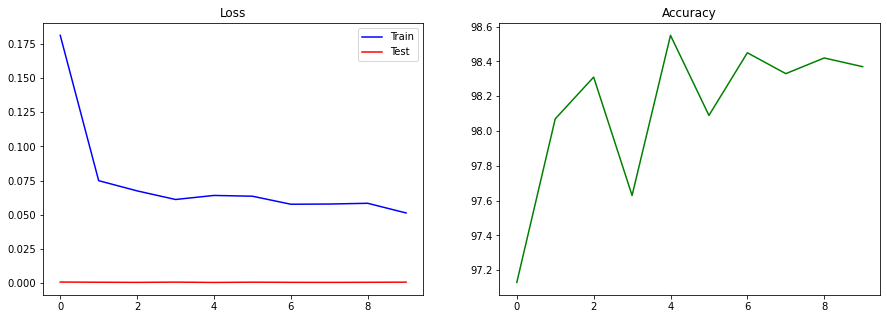

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize= [15,5])
ax1.plot(train_losses,'b', label="Train")
ax1.plot(test_losses,'r', label="Test")
ax1.title.set_text("Loss")
ax1.legend()

ax2.plot(accuracy_list,'g')
ax2.title.set_text("Accuracy")

plt.show()

It is worth noting that the Test set error is too low because we used dropout layers into our CNN. During the evaluation dropout layers are deactivated.

### Compilation of the CAE model

In the CAE model we added noise to the images in two different phases. The first noise addition takes place before the encoder. The last noise addition is done at the output of the encoder.

In [13]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

save_model = True
EPOCHS = 10
momentum = 0.5
learning_rate = 0.01

criterion = nn.MSELoss()
encoder = Encoder().to(device)
decoder = Decoder().to(device)
model_parameters=[
    {'params': encoder.parameters()},
    {'params': decoder.parameters()},
]
optimizer = torch.optim.Adam(
    model_parameters, 
    lr=learning_rate
)
outputs = {
    "input":[],
    "noise":[],
    "recon":[]
}

def add_noise(inputs, ratio= 0.2):
    noise = torch.randn_like(inputs)*ratio
    return inputs + noise

def train(encoder,decoder,data_loader,criterion,optimizer,device,noise=0.2):
    encoder.eval()
    decoder.eval
    train_loss=[]
    for batch_idx, (img, _) in enumerate(data_loader):
        img_noise = add_noise(img, noise)
        img = img_noise.to(device)
        encoded = encoder(img)
        encoded = add_noise(encoded,noise)
        recon = decoder(encoded)
        loss = criterion(recon,img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(img), len(data_loader.dataset),
                100. * batch_idx / len(data_loader), loss.item()))
        train_loss.append(loss.detach().cpu().numpy())
    return np.mean(train_loss)

def test(encoder,decoder,data_loader, loss, device,noise=0.2):
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        conc_out = []
        conc_label = []
        for image_batch, _ in data_loader:
            image_batch = add_noise(image_batch,noise)
            image_batch = image_batch.to(device)
            encod = encoder(image_batch)
            encod = add_noise(encod,noise)
            recon = decoder(encod)
            conc_out.append(recon.cpu())
            conc_label.append(image_batch.cpu())
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)
        val_loss = loss(conc_out,conc_label)
    return val_loss.data


        
for epoch in range(1,EPOCHS+1):
    train_loss = train(encoder,decoder,train_loader,criterion,optimizer,device,0.1)
    val_loss = test(encoder,decoder,test_loader,criterion,device,0.1) 
    print('\n EPOCH {}/{} \t Train-loss: {:.3f} \t Validation-loss: {:.3f}'.format(epoch, EPOCHS,train_loss,val_loss))

if save_model:
    torch.save(encoder,"mnist_cae_encoder.pt")
    torch.save(decoder,"mnist_cae_decoder.pt")



Train Epoch: 1 [0/60000 (0%)]	Loss: 1.176499
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.632279
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.550421
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.518573
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.499281

 EPOCH 1/10 	 Train-loss: 0.585 	 Validation-loss: 0.506
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.511299
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.491337
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.501574
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.489724
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.499647

 EPOCH 2/10 	 Train-loss: 0.494 	 Validation-loss: 0.496
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.489293
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.495368
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.497052
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.484607
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.479122

 EPOCH 3/10 	 Train-loss: 0.488 	 Validation-loss: 0.493
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.470128
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.501

In this phase we load the created CAE model and using a random image batch as an input we get the reconstructed images.

After the reconstruction, we use two metrics.
* **Structural Similarity index**
    * This metric computes the mean structural similarity index between the input image and te reconstructed
    * The SSIM index is a full reference metric; in other words, the measurement or prediction of image quality is based on an initial uncompressed or distortion-free image as reference.
* **Mean Squared Error** 
    * Computes the mean-squared error between two images
    
From these metrics, we acquire the 10 less similar and 10 more similar sets of images.


In [14]:
# Load Model
def mse(imageA, imageB):
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err


def structural_similarity(imgA, imgB):

    s = ssim(np.squeeze(imgA),np.squeeze(imgB))
    return s

def run_model(encoder,decoder, noise, batch, device):
    batch= add_noise(batch,noise)
    encoded = encoder(batch)
    encoded= add_noise(encoded,noise)
    decoded = decoder(encoded)
    decoded = decoded.detach().numpy()
    batch = batch.detach().numpy()
    return encoded, decoded

encoder = torch.load("mnist_cae_encoder.pt")
decoder = torch.load("mnist_cae_decoder.pt")
encoder.eval()
decoder.eval()

# Taking one batch to the model (Randomly)
images =next(iter(test_loader))[0]
noisy_imgs,recon_imgs = run_model(encoder,decoder, 0.1, images, torch.device('cpu'))   
images=images.detach().numpy()

# Calculate te similarity and mse score
similarity_scores = [structural_similarity(images[i], recon_imgs[i])for i in range(images.shape[0])]
mse_scores = [mse(images[i], recon_imgs[i])for i in range(images.shape[0])]
similarity_scores=np.array(similarity_scores)
min_similarity_indices = similarity_scores.argsort()[:10]
max_similarity_indices = similarity_scores.argsort()[-10:]



### Plot the results

Having the minimum and the maximum similarity indices we plot the less and more similar images

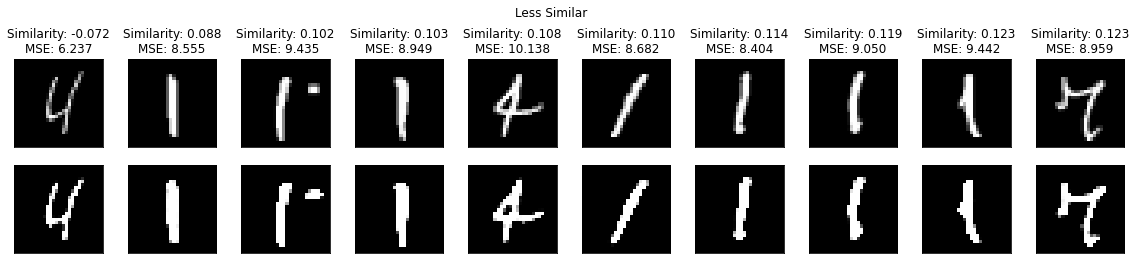

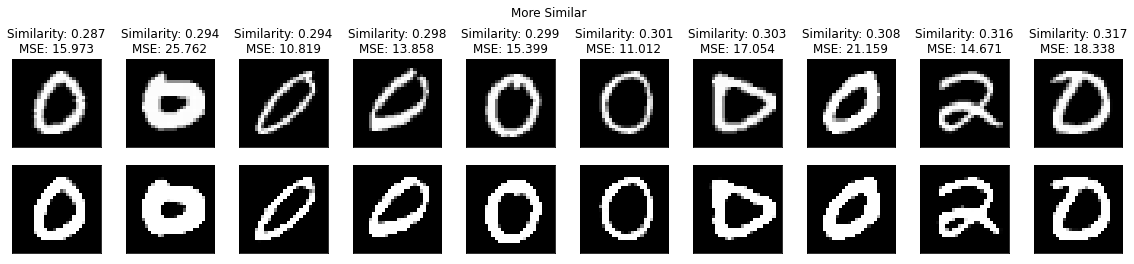

In [15]:
x_axis=2
y_axis=10

fig_less, axs_less = plt.subplots(x_axis, y_axis, figsize=(20,4))
fig_more, axs_more = plt.subplots(x_axis, y_axis, figsize=(20,4))
fig_less.subplots_adjust(top=0.8)
fig_less.suptitle("Less Similar")
plt.gray()
for k, img_id in enumerate(min_similarity_indices):
    axs_less[0,k].set_title("Similarity: {:.3f}\nMSE: {:.3f}".format(similarity_scores[img_id],mse_scores[img_id]))
    axs_less[0,k].imshow(images[img_id,:].reshape(28, 28))
    axs_less[1,k].imshow(recon_imgs[img_id,:].reshape(28, 28))


for ax in axs_less.flat:
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)


fig_more.subplots_adjust(top=0.8)
fig_more.suptitle("More Similar")

for k, img_id in enumerate(max_similarity_indices):
    axs_more[0,k].set_title("Similarity: {:.3f}\nMSE: {:.3f}".format(similarity_scores[img_id],mse_scores[img_id]))
    axs_more[0,k].imshow(images[img_id,:].reshape(28, 28))
    axs_more[1,k].imshow(recon_imgs[img_id,:].reshape(28, 28))


for ax in axs_more.flat:
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)

plt.show()


